# Do-It-Yourself

In this block, the DIY section is more straightforward: we have a few tasks, but they are all around the same dataset. The tasks incorporates all the bits and pieces we have seen on the [hands-on](lab_D) section.

## Data preparation

For this section, we are going to revisit the AHAH dataset we saw in the [DIY section of Block D](../bD/diy_D). Please head over to the section to refresh your mind about how to load up the required data. Once you have successfully created the `ahah` {ref}`object <diy_D:ahah_read>`, move on to Task I.

##### Import Data

In [14]:
import geopandas as gpd
import pandas as pd
from pysal.viz import mapclassify as mc
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from pysal.lib import weights
from splot.esda import moran_scatterplot
import esda

lsoas = gpd.read_file("../bD/data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/shapefiles/E08000012.shp")
ahah_data = pd.read_csv("../bD/data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/tables/E08000012.csv")
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")

## Task I: get the dataset ready

With the `ahah` table on your figertips, complete all the other bits required for the ESDA analysis of spatial autocorrelation:

- Make sure your geography does not have islands
```{margin}
:class: tip
When creating your spatial weights matrix, think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
```
- Create a spatial weights matrix
- Standardise the spatial weights matrix
- Create the standardised version of the AHAH score
- Create the spatial lag of the main AHAH score


#### Task I Answers

##### Create spatial weights and remove islands (if necessary)

In [15]:
knn_weights = weights.KNN.from_dataframe(ahah, k=5)

In [16]:
knn_weights.islands

[]

##### Standardise spatial weights

In [17]:
knn_weights.transform = 'R'

##### Standardise AHAH score

In [18]:
ahah['ahah_z'] = (ahah['ahah'] - ahah['ahah'].mean()) / ahah['ahah'].std()

##### Create spatial lag

In [20]:
ahah['ahah_lag'] = weights.lag_spatial(knn_weights, ahah['ahah_z'])

## Task II: global spatial autocorrelation

Let's move on to the analytics:

- Visualise the main AHAH score with a Moran Plot
- Calculate Moran's I
- *What conclusions can you reach from the Moran Plot and Moran's I? What's the main spatial pattern?*

#### Task II Answers

##### Moran plot - with and then without esda lib

In [23]:
morans_i = esda.Moran(ahah['ahah_lag'], knn_weights)

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.88)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

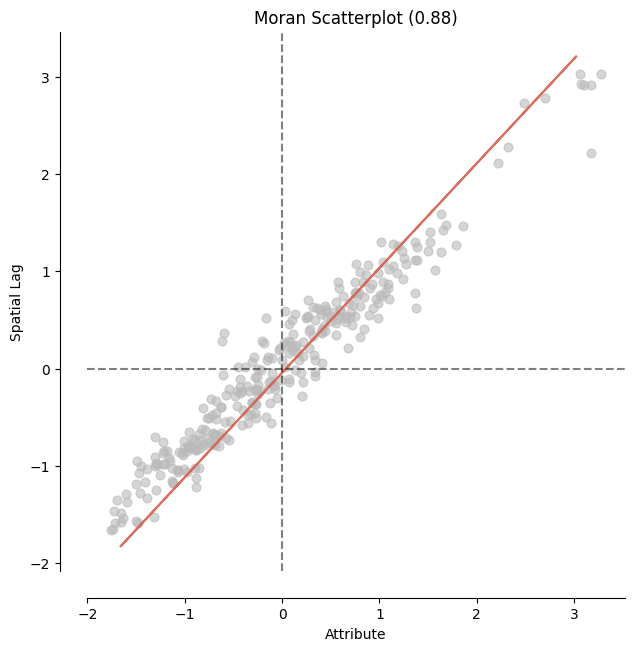

In [24]:
moran_scatterplot(morans_i)

/tmp/ipykernel_24215/4230931970.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


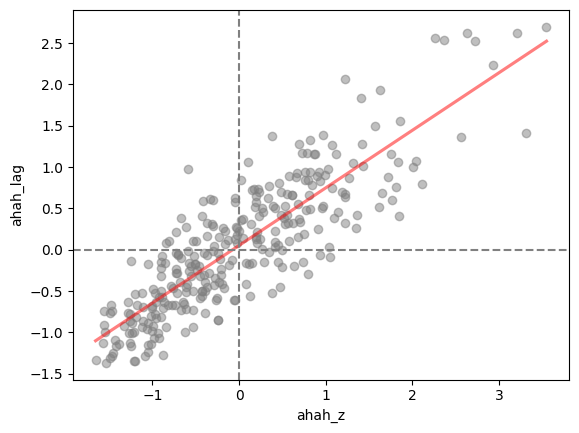

In [46]:
f, ax = plt.subplots(1)

ALPHA = 0.5

sns.regplot(x=ahah['ahah_z'], y=ahah['ahah_lag'], ci=None, ax=ax, line_kws={'color':'red', 'alpha':ALPHA}, scatter_kws={'color':'grey', 'alpha':ALPHA})

ax.axvline(0, linestyle='--', color='grey')
ax.axhline(0, linestyle='--', color='grey')

f.show()

##### Calculate Morans I

In [48]:
print(f"""
    Morans I: {morans_i.I},
    P-Value: {morans_i.p_sim}
""")


    Morans I: 0.8750074073824187,
    P-Value: 0.001



#### What does the Morans I tell us?

The morans i and p-value above indicate that there is a significant (p < 0.001) global positive autocorrelation of the ahah variable (it is very high also, since Morans I = 0.88). This implies that the trend across Liverpool of AHAH is that areas with high (low) AHAH tend to be surrounded by other areas with high (low) AHAH. The p-value implies that across a number of simulations where the same values are used but their location is randomised, in only 0.1% of the simulations would the calculated Morans I be larger than this. The Morans I is also equal to (or just indicative of?) the slope of the best fit line.

## Task III: local spatial autocorrelation

Now that you have a good sense of the overall pattern in the AHAH dataset, let's move to the local scale:

- Calculate LISA statistics for the LSOA areas
- Make a map of significant clusters at the 5%
- *Can you identify hotspots or coldspots? If so, what do they mean? What about spatial outliers?*
````{margin}
```{warning}
The last action is a bit more sophisticated, put all your brain power into it and you'll achieve it!
```
````
- Create cluster maps for significance levels 1% and 10%; compare them with the one we obtained. *What are the main changes? Why?*

#### Task III Answers

##### Calculate LISA Stats for LSOA areas

In [56]:
# Block weights don't seem as though they would be terribly useful here. Every polygon is its own block so there would be 0 neighbors.
block_weights = weights.block_weights(ahah['lsoa11cd'])
block_weights.mean_neighbors

/home/tristannew/code/gds_course/.venv/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 298 disconnected components.
 There are 298 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 

0.0

In [57]:
# I will use contiguity weights instead here using the Rook contiguity.
rook_weights = weights.Rook.from_dataframe(ahah)

/tmp/ipykernel_24215/3631753066.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  rook_weights = weights.Rook.from_dataframe(ahah)


In [58]:
# Going to use the knn weights here for comparibility but I think Rook might be better in practice.
lisa = esda.Moran_Local(ahah['ahah'], knn_weights)

##### Map of clusters at 5%

In [63]:
ahah['quadrant'] = lisa.q

/tmp/ipykernel_24215/3210128718.py:17: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  hl.plot(ax=axis, color='blue')
/tmp/ipykernel_24215/3210128718.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


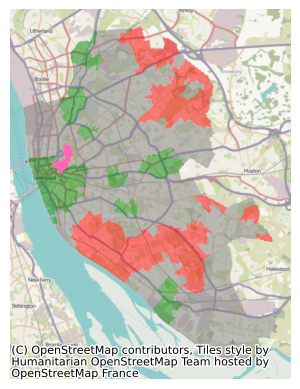

In [78]:
def make_plot_for_significance_level(alpha, axis, title=None):

    ahah['significant'] = lisa.p_sim <= alpha

    non_sigs = ahah[ahah['significant'] == False]
    non_sigs.plot(ax=axis, color='grey', alpha=0.5)

    sigs = ahah[ahah['significant'] == True]

    hh = sigs[sigs['quadrant'] == 1]
    hh.plot(ax=axis, color='green', alpha=0.5)

    ll = sigs[sigs['quadrant'] == 3]
    ll.plot(ax=axis, color='red', alpha=0.5)

    hl = sigs[sigs['quadrant'] == 4]
    hl.plot(ax=axis, color='blue')

    lh = sigs[sigs['quadrant'] == 2]
    lh.plot(ax=axis, color='#FF69B4')

    cx.add_basemap(ax=axis, crs=ahah.crs)

    axis.set_axis_off()

    if title:
        axis.set_title(title)

    f.show()

f, ax = plt.subplots(1)
make_plot_for_significance_level(alpha=0.05, axis=ax)

The above shows that near the city centre (I think that is where it is) there is a spatial outlier; an LSOA that has a low level of AHAH (i.e. poor 'health' in terms of its access to healthy assets and hazards) that is surrounded by other LSOAs with high AHAH (i.e. good access to healthy assets, or good 'health'). Also, hotspots are in green (HH), coldspots are in red (LL).

##### Cluster maps for 1% and 10%

/tmp/ipykernel_24215/3210128718.py:17: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  hl.plot(ax=axis, color='blue')
/tmp/ipykernel_24215/3210128718.py:20: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  lh.plot(ax=axis, color='#FF69B4')
/tmp/ipykernel_24215/3210128718.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_24215/3210128718.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


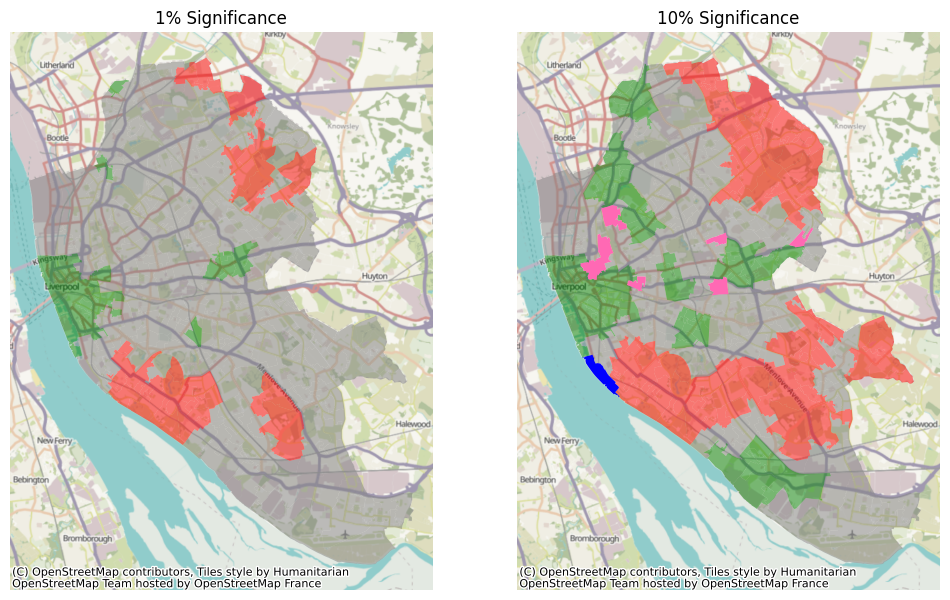

In [79]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))

make_plot_for_significance_level(alpha=0.01, axis=ax1, title="1% Significance")
make_plot_for_significance_level(alpha=0.1, axis=ax2, title="10% Significance")

The main changes above are that we can either see more (in the 1%) or less (in the 10%) spatial outliers and cold/hotspots depending on the signficance that we choose. The reason for this is likely because cold/hotspots and spatial outliers represent some kind of spatial relationship, the null hypothesis is that there are no relationships and therefore the p-value represents the likelihood of our results if the null hypothesis were true (if there was no relationship). As we increase the significance level we are saying that we are now happy to call a relationship as significant when there is a 10% chance that our results have occurred by chance. Every statistical test returns a value that provides information on a relationship between variables (space and AHAH, in this case) but the p-value and similar tools tell us whether these relationship are actually relationships (does AHAH actually vary across space) or were these results simply generated by chance.